<a href="https://colab.research.google.com/github/waelfayyad/robust/blob/main/SOLUTIONS_HW03_Uncertainty_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Homework #3: Uncertainty in ML!
In this homework assignment, you will complete the following three tasks:


1.   Implement Gaussian negative log likelihood training to characterize aleatoric uncertainty in a regression problem.
2.   Implement the max softmax method for detecting OMS inputs. [(paper)](https://arxiv.org/pdf/1610.02136.pdf)
3.   Implement functionality for calculating the AUROC OMS detection metric.

##IMPORTANT:
  > Before you get started, select `Runtime > Change runtime type` and select `GPU` for your hardware accelerator.

##A couple of notes
1. Make sure to run each cell in order!
2. Only fill in code in sections marked as follows:
```
# <<<<<< Put your code here
# Write your code
# >>>>>
```

Let's get started!





# Part 1: Predicting aleatoric uncertainty

In this portion of the assignment, we will be characterizing the aleatoric uncertainty of a vision-based aircraft taxi navigation system.

## Environment setup

Run the cell below to load the packages we need for the worksheet. See the comments for the purpose of each

In [ ]:
import os # Used to check the existence of files that we download
import h5py # Used to load the dataset
import numpy as np # Numpy used for general array manipulation
import matplotlib.pyplot as plt # Used for showing images
import copy # Used to make copies of network
from sklearn import metrics # Used for computing AUROC

import torch # Pytorch library used for defining and training ML models
import torchvision # Package with utilities for computer vision such as pretrained models
import torchvision.datasets as datasets # Used for MNIST and FashionMNIST
import torch.nn as nn # the neural network library used for defining models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Used for wrapping and iterating throughout data

from tqdm import tqdm # Progress bar while training
import warnings # Give warnings, such as if CUDA is unavailable
import multiprocessing # Allows us to check the number of available CPUS

Now we check that GPU-support is available. If not, you may have forgotten to select the GPU hardware accelerator. We also set some useful constants.

In [ ]:
if not torch.cuda.is_available():
    warnings.warn(
        "CUDA is not available, please check that you have selected a GPU for hardware acceleration"
    )

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CORES = multiprocessing.cpu_count()

## Download and visualize the data

Next, we will download and visualize the aircraft hold line detection dataset. Airports have a number of signs and ground markings that taxiing aircraft must follow. [Check out a complete list of airport markings here](https://www.faa.gov/air_traffic/publications/atpubs/aim_html/chap2_section_3.html). In this assignment, we will focus on holding position markings, which are represented by dashed yellow lines. Aircraft must stop before reaching these markings if clearance has not been issued by air traffic control. We will be training a neural network to predict the aircraft's distance to the hold position marking using a dataset of simulated images from the [X-Plane 11 Flight Simulator](https://www.x-plane.com). Run the following cell to download the data:

In [ ]:
!gdown https://drive.google.com/uc?id=1Tu6hbveAI8DFF2owvpJChRBIMjBJS6AB
!gdown https://drive.google.com/uc?id=1hYWyFdk2XuWbnhioNJ6tuLg81Q7huHhE

# Check for successful download
print()
if os.path.isfile('hold_data.h5') and os.path.isfile('test_hold_data.h5'):
  print('Download successful!')
else:
  print('Error downloading data.')

Downloading...
From: https://drive.google.com/uc?id=1Tu6hbveAI8DFF2owvpJChRBIMjBJS6AB
To: /content/hold_data.h5
100% 328M/328M [00:01<00:00, 173MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hYWyFdk2XuWbnhioNJ6tuLg81Q7huHhE
To: /content/test_hold_data.h5
100% 444k/444k [00:00<00:00, 130MB/s]



NameError: ignored

Run the following cell to load in the training, validation, and test datasets:

In [ ]:
# Training and validation images
f = h5py.File('hold_data.h5')
images = np.array(f['color_imgs']) / 255
labels = -np.array(f['dtps'])

# Filter out images too close to the hold line
images = images[labels > 1.5]
labels = labels[labels > 1.5]

# Test images
f = h5py.File('test_hold_data.h5')
test_images = np.transpose(np.array(f['imgs']) / 255, (3, 0, 1, 2))

Now let's visualize some example images at various distances from the hold line.

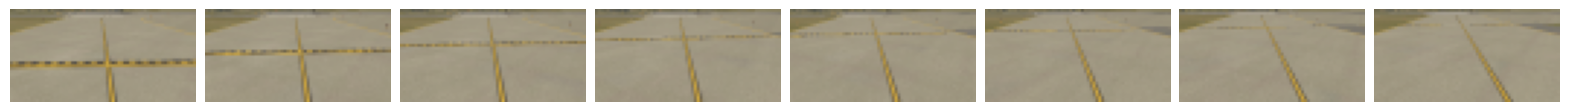

In [ ]:
# Manual order from closest to furthest
order = [6, 7, 5, 8, 3, 2, 1, 4]

# Plot the images
fig, axs = plt.subplots(1, 8, figsize=(20, 3))

for (i, img_num) in enumerate(order):
  axs[i].imshow(test_images[img_num])
  axs[i].axis('off')

plt.subplots_adjust(wspace=0.05)
plt.show()

Visually, it looks easier to predict the distance to the hold line accurately when it is closer to the aircraft. In this assignment, we will train a neural network using the Gaussian negative log likelihood method to reflect these differences in prediction uncertainty.

## Create pytorch dataset and training/validation splits

The following cell creates a `TaxiDataset` class that we can use with our pytorch models.

In [ ]:
class TaxiDataset(Dataset):
  def __init__(self, images, labels):
    self.images = torch.Tensor(np.transpose(images, (0, 3, 1, 2))) # get into n x c x h x w
    self.labels = torch.Tensor(labels[:, np.newaxis])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx] / 20

We will split the data into training and validation sets using the last 200 images as the validation set.

In [ ]:
train_dataset = TaxiDataset(images[:-200], labels[:-200])
valid_dataset = TaxiDataset(images[-200:], labels[-200:])

## Define our model and evaluation functions

We will use a common convolutional neural network architecture called LeNet5 for our hold marking prediction network. The following code defines this model in pytorch.

In [ ]:
class LeNet5(nn.Module):
  def __init__(self, img_size=(3, 32, 64), out_dim=2):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(img_size[0], 6, kernel_size=5),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))
    self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))
    self.flatten = nn.Flatten()

    fc1_input_size = (int(img_size[1] / 4) - 3) * (int(img_size[2] / 4) - 3) * 16
    self.fc1 = nn.Sequential(nn.Linear(fc1_input_size, 120),
                             nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(120, 84),
                             nn.ReLU())
    self.output = nn.Linear(84, out_dim)

  def forward(self, x):
    tmp = self.conv1(x)
    tmp = self.conv2(tmp)
    tmp = self.flatten(tmp)
    tmp = self.fc1(tmp)
    tmp = self.fc2(tmp)
    output = self.output(tmp)
    return output

This function computes the predictions of the model on the dataset, returning the true and predicted labels.

Fill in the code to get the model predictions and extract the mean and variance.

**Hint 1:** Our model will take in the 32x64 color images and produce a two-dimensional output where the first output is the mean of the predicted distance to the hold marking and the second output relates to the variance.

**Hint 2:** To ensure our predicted variance is always positive, we need to apply the [softplus function](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) to the second output to obtain the variance.

In [ ]:
def get_predictions(model, dataset, batch_size=32):
    # Put the model on the target device
    model = model.to(DEVICE)

    # Construct a dataloader with the specified batch size
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=N_CORES)

    # Empty arrays for storing labels and predictions and groups
    ypred = []
    varpred = []
    y = []

    # Put the model in eval model and don't store gradients
    model.eval()
    with torch.no_grad():
        # Loop through all data in batches
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # <<<<<< Put your code here
            # Compute model outputs [1 line]
            predicted = model(inputs)

            # Extract the mean and variance (remember to apply softplus to the variance) [2 lines]
            mean_pred = predicted[:, 0]
            var_pred = nn.Softplus()(predicted[:, 1])
            # >>>>>

            # Store the results
            ypred.extend(mean_pred.cpu().numpy())
            varpred.extend(var_pred.cpu().numpy())
            y.extend(labels.cpu().numpy())

    # Scale the outputs by a factor of 20 to undo normalization in dataloader
    return np.array(y) * 20, np.array(ypred) * 20, np.array(varpred) * 400

## Gaussian negative log likelihood training

The following function will train the model using the [Gaussian negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html). To promote better performance, we will return the model that had the lowest validation loss rather than the final model. Fill in the missing parts below to complete the function.

In [ ]:
def train_nll(
    model,
    dataset,
    valid_dataset,
    batch_size=128,
    num_epochs=1,
    learning_rate=1e-3
):
    # Move the model to the device
    model = model.to(DEVICE)
    best_model = copy.deepcopy(model)
    curr_best_val = 1000

    # <<<<<< Put your code here
    # Define the criterion to be used in the loss function [1 line]
    loss_fn = nn.GaussianNLLLoss()
    # >>>>>

    # Define the optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate)

    # Construct the DataLoaders
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=N_CORES
    )
    validloader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=N_CORES
    )

    # Construct the progess bar
    num_batches = len(dataloader)
    progress_bar = tqdm(
        total=num_batches * num_epochs, desc="Training Progress", position=0, leave=True
    )

    # Loop over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Put the model into train mode
        model.train()

        # Loop over data
        for (i, (inputs, labels)) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # <<<<<< Put your code here
            # Zero the gradients in the optimizer [1 line]
            optimizer.zero_grad()

            # Compute the model outputs [1 line]
            outputs = model(inputs)

            # Extract the mean and variance (remember to apply softplus to the variance) [2 lines]
            mu = outputs[:, 0]
            var = nn.Softplus()(outputs[:, 1])

            # compute the loss according the criterion (call this variable loss) [1 line]
            loss = loss_fn(mu[:, None], labels, var[:, None])

            # Compute gradients of the loss and step the optimizer [2 lines]
            loss.backward()
            optimizer.step()
            # >>>>>

            # Accumulate the running loss and update the progress bar
            running_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix({'Epoch': epoch+1, 'Batch': i+1, 'Train_Loss': running_loss / (i+1)})

        running_loss = 0.0

        #### Code to return model with lowest validation loss ####

        # Put the model input eval mode
        model.eval()

        # Loop over validation data
        for (i, (inputs, labels)) in enumerate(validloader):
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          # <<<<<< Put your code here
          # Compute the model outputs [1 line]
          outputs = model(inputs)

          # Extract the mean and variance [2 lines]
          mu = outputs[:, 0]
          var = nn.Softplus()(outputs[:, 1])

          # compute the loss according the criterion (call this variable loss) [1 line]
          loss = loss_fn(mu[:, None], labels, var[:, None])
          # >>>>>

          # Accumulate running loss
          running_loss += loss.item()

        # Determine if current best val loss
        if running_loss / (i + 1) < curr_best_val:
          curr_best_val = running_loss / (i + 1)
          best_model = copy.deepcopy(model)

    return best_model, curr_best_val


    progress_bar.close()

Let's train a model! This should take about 1 minute.

In [ ]:
model = LeNet5(out_dim=2)
best_model, best_val = train_nll(model, train_dataset, valid_dataset, num_epochs=50, learning_rate=1e-3)
print('')
print('Validation Loss: ', best_val)

Training Progress: 100%|██████████| 1750/1750 [00:48<00:00, 35.94it/s, Epoch=50, Batch=35, Train_Loss=-2.75]


Validation Loss:  -3.538792133331299


For good performance, the validation loss should be less than `-2.5`.

## Evaluate the model and its predicted uncertainty

Let's see how it did! Run the following cell to plot the model predictions on the validation set.

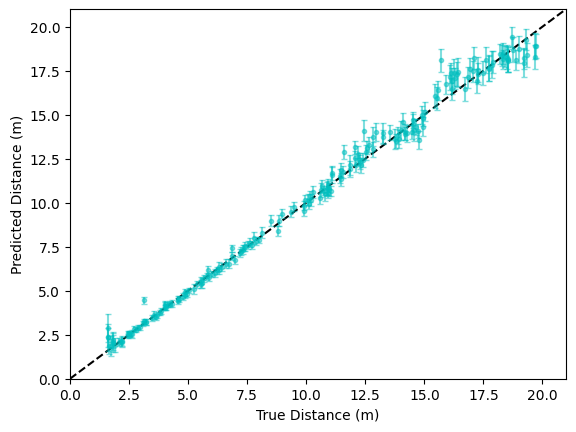

In [ ]:
# Get predictions
y, ypred, varpred = get_predictions(best_model, valid_dataset)

# Plot true value vs. predicted mean and standard deviation
plt.plot([0, 21], [0, 21], '--', c='k')
plt.errorbar(y, ypred, yerr=np.sqrt(varpred), capsize=2, fmt='o', alpha=0.5, c='c', markersize=3.0)
plt.xlim([0, 21])
plt.ylim([0, 21])
plt.xlabel('True Distance (m)')
plt.ylabel('Predicted Distance (m)')
plt.show()

The predictions should roughly follow the dotted line (which represents where the predicted label matches the true label). The error bars show one standard deviation according to the predicted uncertainty from the model. You should see that the error bars are larger as the aircraft gets further from the hold line, consistent with our initial observations from the earlier visualization!

Finally, let's plot the model predictions on the test images we visualized earlier:

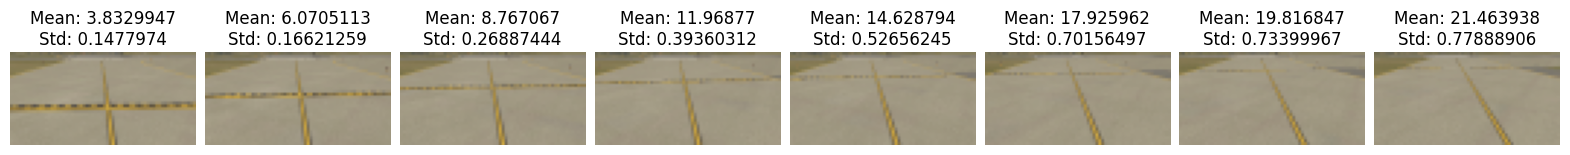

In [ ]:
# Get the predictions
outputs = best_model(torch.Tensor(np.transpose(test_images, (0, 3, 1, 2))).to(DEVICE))
mu = outputs[:, 0].cpu().detach().numpy() * 20
var = nn.Softplus()(outputs[:, 1]).cpu().detach().numpy() * 400

# Manual order from closest to furthest
order = [6, 7, 5, 8, 3, 2, 1, 4]

# Plot the images
fig, axs = plt.subplots(1, 8, figsize=(20, 3))

for (i, img_num) in enumerate(order):
  axs[i].imshow(test_images[img_num])
  title_string = 'Mean: ' + str(mu[img_num]) + '\nStd: ' + str(np.sqrt(var[img_num]))
  axs[i].set_title(title_string)
  axs[i].axis('off')

plt.subplots_adjust(wspace=0.05)
plt.show()

# Part 2: Out-of-model-scope (OMS) detection
In this portion of the assignment, we will be creating an OMS detector for the MNIST dataset using the max softmax method described in [Hendrycks and Gimpel (2017)](https://arxiv.org/pdf/1610.02136.pdf).

## Download and visualize the data

First, we will download the MNIST dataset, which consists of images of handwritten digits with labels 0-9. We will also load the Fashion MNIST dataset as an out-of-distribution dataset, which consists of labeled images of 10 different types of clothing that are the same size as the handwritten digit images. Run the cell below to download the datasets.

In [ ]:
# Download and load in the MNIST dataset
mnist_train = datasets.MNIST(root='', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_valid = datasets.MNIST(root='', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Download and load in the Fashion MNIST dataset
fashion_mnist_train = datasets.FashionMNIST(root='', train=True, download=True, transform=torchvision.transforms.ToTensor())
fashion_mnist_valid = datasets.FashionMNIST(root='', train=False, download=True, transform=torchvision.transforms.ToTensor())

Next, let's visualize some images from each dataset. Run the following cell to display a plot where the top row shows images from the MNIST dataset and the bottom row displays images from the Fashion MNIST dataset.

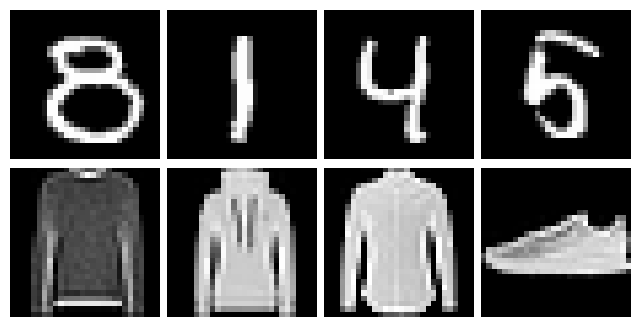

In [ ]:
# Sample four random images
np.random.seed(13)
sample_inds = np.random.randint(0, len(mnist_valid), 4)

# Plot the images from MNIST and Fashion MNIST
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

# MNIST images
for i in range(4):
    axs[0][i].imshow(mnist_valid[sample_inds[i]][0][0], cmap='gray')
    axs[0][i].axis('off')

# Fashion MNIST images
for i in range(4):
    axs[1][i].imshow(fashion_mnist_valid[sample_inds[i]][0][0], cmap='gray')
    axs[1][i].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Train an MNIST classifier

We will use the same model architecture (LeNet5) that we used for the taxi hold line predictor network, modified to take as input a 128x128 grayscale image and output a 10-dimensional logit vector corresponding to each digit class. Fill in the missing pieces of the code below to train a classifier network on the MNIST dataset using a cross entropy loss.

In [ ]:
def train_mnist(
    model,
    dataset,
    batch_size=128,
    num_epochs=1,
    learning_rate=1e-3
):
    # Move the model to the device
    model = model.to(DEVICE)

    # <<<<<< Put your code here
    # Define the criterion to be used in the loss function [1 line]
    loss_fn = nn.CrossEntropyLoss()
    # >>>>>

    # Define the optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate)

    # Construct the DataLoaders
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=N_CORES
    )

    # Construct the progess bar
    num_batches = len(dataloader)
    progress_bar = tqdm(
        total=num_batches * num_epochs, desc="Training Progress", position=0, leave=True
    )

    # Put the model into train mode
    model.train()

    # Loop over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Loop over data
        for (i, (inputs, labels)) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # <<<<<< Put your code here
            # Zero the gradients in the optimizer [1 line]
            optimizer.zero_grad()

            # Compute the model outputs (logits) [1 line]
            logits = model(inputs)

            # compute the loss according the criterion (call this variable loss) [1 line]
            loss = loss_fn(logits, labels)

            # Compute gradients of the loss and step the optimizer [2 lines]
            loss.backward()
            optimizer.step()
            # >>>>>

            # Accumulate the running loss and update the progress bar
            running_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix({'Epoch': epoch+1, 'Batch': i+1, 'Train_Loss': running_loss / (i+1)})

    progress_bar.close()

Run the code below to create the model and train it. It should take around a minute to run.

In [ ]:
model = LeNet5(img_size=(1, 28, 28), out_dim=10)
train_mnist(model, mnist_train, num_epochs=5, learning_rate=1e-3)

Training Progress: 100%|██████████| 2345/2345 [01:03<00:00, 36.76it/s, Epoch=5, Batch=469, Train_Loss=0.0491]


The training loss should be `~0.05` if implemented correctly.

## Implement OMS detection

First, we will create a function to evaluate a trained model on a validation dataset. We will output the true labels, the predicted labels, the softmax probabilities of the predicted label (in other word, the max softmax), and the accuracy of the classifier on the dataset. Fill in the missing pieces of the code below to create this function.

In [ ]:
def evaluate_classifier(model, dataset, batch_size=32):
    # Put the model on the target device
    model = model.to(DEVICE)

    # Construct a dataloader with the specified batch size
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=N_CORES)

    # Empty arrays for storing labels and predictions and groups
    y = []
    ypred = []
    pred_probs = []

    # Put the model in eval model and don't store gradients
    model.eval()
    with torch.no_grad():
        # Loop through all data in batches
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # <<<<<< Put your code here
            # Compute model outputs (logits)
            logits = model(inputs)

            # Get softmax probabilities
            softmax_probs = nn.Softmax(1)(logits)

            # Get predicted labels and their corresponding softmax probabilities
            # Call the predicted labels pred and the softmax probabilities pred_prob
            pred_prob, pred = torch.max(softmax_probs, 1)
            # >>>>>

            # Store the results
            y.extend(labels.cpu().numpy())
            ypred.extend(pred.cpu().numpy())
            pred_probs.extend(pred_prob.cpu().numpy())

    # Compute accuracy
    accuracy = np.sum(np.array(y) == np.array(ypred)) / len(dataset)

    # Scale the outputs by a factor of 20 to undo normalization in dataloader
    return np.array(y), np.array(ypred), np.array(pred_probs), accuracy

Run the cell below to evaluate the trained MNIST classifier on both the MNIST and Fashion MNIST validation sets.

In [ ]:
y, ypred, pred_probs, acc = evaluate_classifier(model, mnist_valid)
f_y, f_ypred, f_pred_probs, f_acc = evaluate_classifier(model, fashion_mnist_valid)
print('MNIST Validation Accuracy: ', acc)

MNIST Validation Accuracy:  0.9856


The validation accuracy should be high for the MNIST dataset (above 98%).

Next, we will build an OMS detector for our classifier. Ideally, we want to flag images with either of the following two properties as OMS (since both conditions would lead to erroneous predictions):

1.   MNIST images that our classifier gets wrong
2.   Fashion MNIST images

To accomplish this, we will use the softmax probability of the predicted label for each input (i.e. the max softmax) to determine whether an input is OMS. We hypothesize that OMS images will have a low softmax probability of the predicted label. Run the following cell to visualize the distribution over this value for each class of inputs.



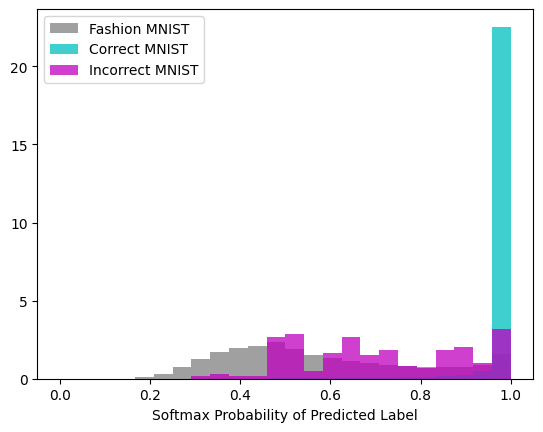

In [ ]:
plt.hist(f_pred_probs, bins=np.linspace(0, 1, 25), density=True, color='0.5', alpha=0.75, label='Fashion MNIST')
plt.hist(pred_probs[y == ypred], bins=np.linspace(0, 1, 25), density=True, color='c', alpha=0.75, label='Correct MNIST')
plt.hist(pred_probs[y != ypred], bins=np.linspace(0, 1, 25), density=True, color='m', alpha=0.75, label='Incorrect MNIST')
plt.xlabel('Softmax Probability of Predicted Label')
plt.legend()
plt.show()

As hypothesized, the correctly predicted MNIST images tend to have high softmax probabilities of their predicted labels, while the incorrectly predicted MNIST images and the Fashion MNIST images tend to have lower values. This is a good result! It means that we can use the softmax probability of the predicted label to reasonably separate in-model-scope inputs from out-of-model-scope inputs by selecting a threhold and flagging inputs with values lower than the threshold as OMS.

However, the distributions do overlap slightly, so we cannot achieve a perfect OMS detector regardless of the threshold we select for the softmax probability of the predicted label. Let's analyze this result further by computing the Receiver Operating Characteristics (ROC) curve and computing the AUROC.

Fill in the code below to compute the values along the ROC curve. We will use the `metrics` package from `scikit-learn` to compute the values given the labels true labels of whether inputs are OMS and the computed scores (based on the softmax probability of the predicted class).

**NOTE:** we will use the convention that a label of 1 means the datapoint is in-model-scope and a label of zero means the datapoint is out-of-model-scope.

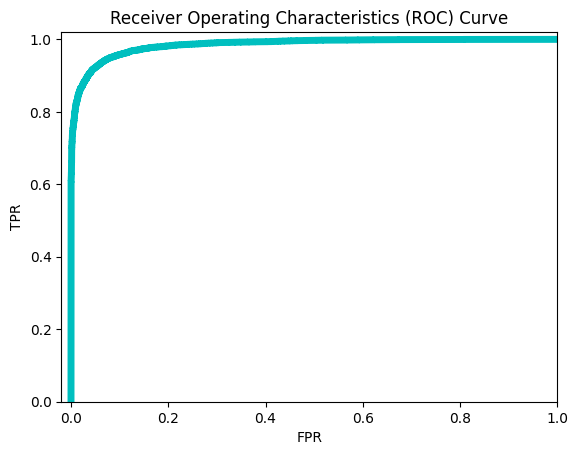

In [ ]:
# <<<<<< Put your code here
# Compute a vector of true OMS labels (whether each point is OMS) [1 line]
# HINT 1: you should hstack the OMS labels for the MNIST datapoints and the OMS labels for the Fashion MNIST datapoints
# HINT 2: for the MNIST datapoints, the oms label should be 1 if the classifier gets the input correct and 0 (OMS) otherwise
# HINT 3: the Fashion MNIST datapoints are all OMS
# HINT 4: use the outputs we computed using the evaluate classifier function
true_oms_labels = np.hstack((y == ypred, np.zeros(len(fashion_mnist_valid))))

# Compute a vector of OMS scores (the softmax probabilities of the predicted class) [1 line]
# HINT: you should hstack the OMS scores for the MNIST datapoints and the OMS scores for the Fashion MNIST datapoints
oms_scores = np.hstack((pred_probs, f_pred_probs))
# >>>>>

# Compute the datapoints on the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(true_oms_labels, oms_scores)

plt.plot(fpr, tpr, c='c', lw=5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristics (ROC) Curve')
plt.xlim(-0.02, 1.0)
plt.ylim(0.0, 1.02)
plt.show()

To obtain the popular OMS assessment metric, we can compute the area under this curve as follows.

In [ ]:
auroc = metrics.auc(fpr, tpr)
print('Area under the receiver operating characteristics curve (AUROC): ', auroc)

Area under the receiver operating characteristics curve (AUROC):  0.9844602476769584


You should get an AUROC around `~0.98`. This result is pretty good, especially for this simple method! You may also notice that the ROC looks close to the ideal curve shown in lecture.

## Conclusion and Bonus Activities


---



Congratulations on completing the assignment! You can stop here, or if you want to try out some additional concepts from lecture consider trying one of the following

1. Experiment with other logit-based OMS detection techniques.
2. Experiment with Bayesian OMS detection techniques such as:

*   [Deep Ensembles](https://proceedings.neurips.cc/paper_files/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf)
*   [Monte Carlo Dropout](http://proceedings.mlr.press/v48/gal16.pdf)